In [1]:
import pickle
import cv2

pickle_data_path = './test_images/dist_pickle.p'
dist_pickle = pickle.load(open(pickle_data_path, 'rb'))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
# cal_col
nx = dist_pickle["nx"]
# cal_row
ny = dist_pickle["ny"]

In [2]:
import numpy as np

# This function is just for initial test. It will be further break down to smaller utility functions

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
#         Corners dimensionality cal_col (nx) * cal_col (ny)
# In UL, UR, LR, LF (clockwise sequence)
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

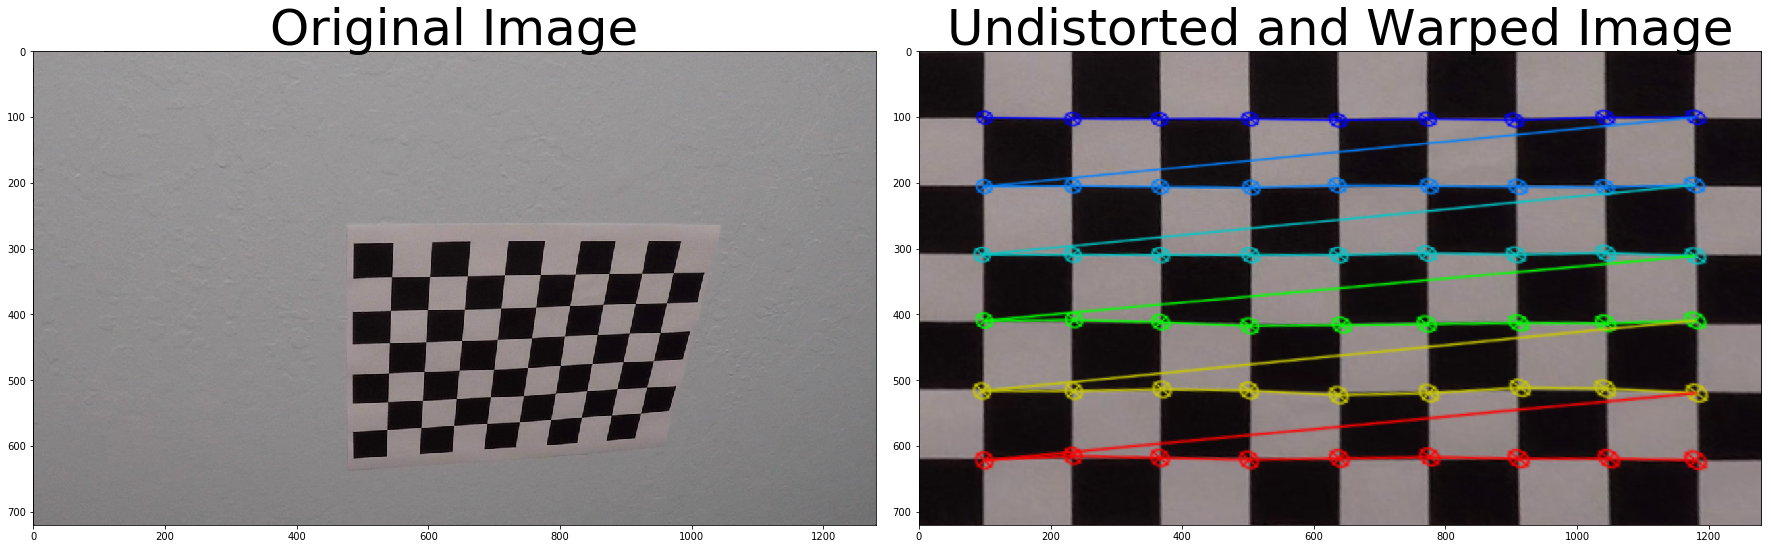

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline
# %matplotlib qt

img_path = './camera_cal/calibration10.jpg'
img = cv2.imread(img_path)
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

img_shape = img.shape

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [4]:
    def visualize(filename, a):
        fig, axes = plt.subplots(2,3,figsize=(24,12),subplot_kw={'xticks':[],'yticks':[]})
        fig.subplots_adjust(hspace=0.03, wspace=0.05)
        for p in zip(sum(axes.tolist(),[]), a):
            p[0].imshow(p[1],cmap='gray')
        plt.tight_layout()
        plt.show()
        fig.savefig(filename)
        plt.close()

    def visualize_2(filename, a):
        fig, axes = plt.subplots(1,2,figsize=(12,6),subplot_kw={'xticks':[],'yticks':[]})
        fig.subplots_adjust(hspace=0.03, wspace=0.05)
        for p in zip(axes.tolist(), a):
            p[0].imshow(p[1],cmap='gray')
        plt.tight_layout()
        plt.show()
        fig.savefig(filename)
        plt.close()

### Original Test Images

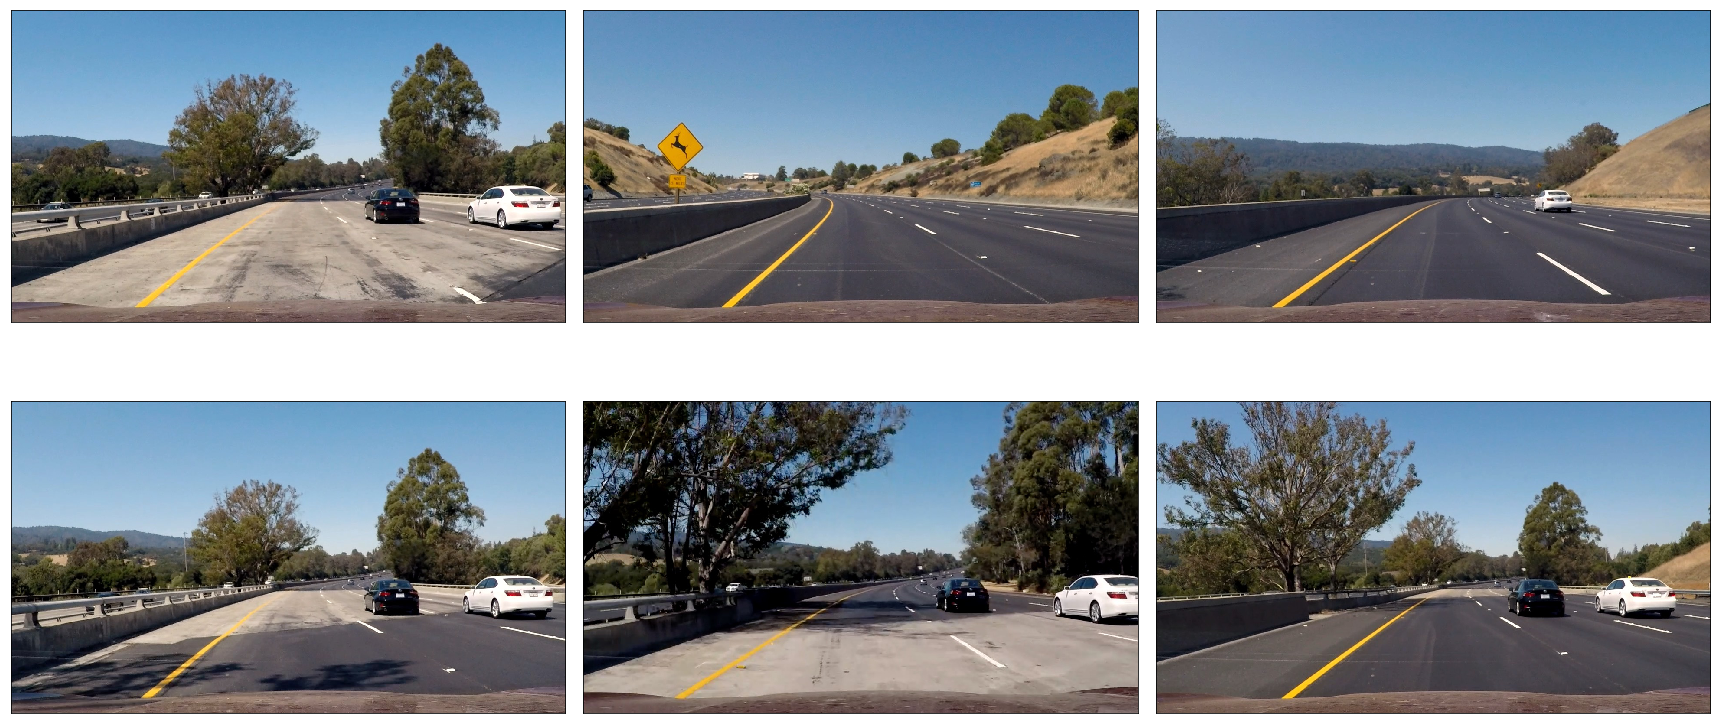

In [5]:
from itertools import cycle
visualize("output_images/test_images.jpg",
            (mpimg.imread(f) for f in cycle(glob.glob("test_images/test*.jpg"))))

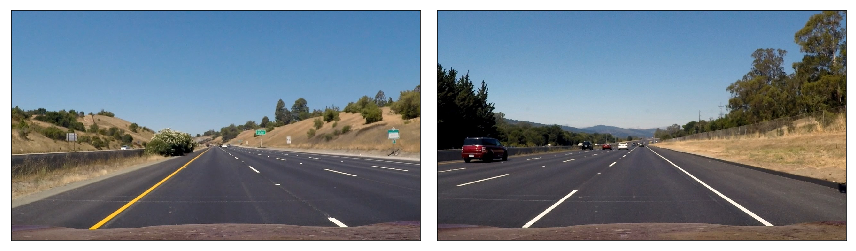

In [6]:
visualize_2("output_images/straight_lines.jpg",
            (mpimg.imread(f) for f in cycle(glob.glob("test_images/straight_lines*.jpg"))))

### Undistorted and Warp Test Images

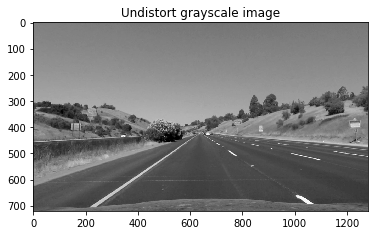

In [86]:
# top_down, perspective_M = corners_unwarp((mpimg.imread(f) for f in cycle(glob.glob("test_images/test*.jpg"))), nx, ny, mtx, dist)

# Interactive plot
# %matplotlib notebook
%matplotlib inline

img_path = './test_images/straight_lines1.jpg'
img = cv2.imread(img_path)
# top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

def undistort(img, mtx=mtx, dist=dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def undistort_show(img, mtx, dist):
#     undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist = undistort(img, mtx, dist)
    gray = grayscale(undist)
    plt.imshow(gray, cmap='gray')
    plt.title("Undistort grayscale image")

    
# TODO: Matplotlib interactive event handler listen mouse click to record pixel position
undistort_show(img, mtx, dist)

# Manually pick X, Y
base_points = [[528.482, 501.855], [768.492, 501.855], [1073.01, 705.726], [231.718, 705.726]]

def warped(img, nx, ny, base_points, offset=100):
    """
    base_points: [[], [], [], []] four points chosen for forming parallax, vertical and horizontal
    """
#     offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])

    # For source points I'm grabbing the outer four detected corners
#         Corners dimensionality cal_col (nx) * cal_col (ny)
# In UL, UR, LR, LF (clockwise sequence)
#     src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    src = np.float32(base_points)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]-offset], 
                      [offset, img_size[1]-offset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, M

### Interactively Select parallex points in pictures 

http://matplotlib.org/users/event_handling.html

http://matplotlib.org/1.3.0/examples/event_handling/pick_event_demo.html

 ### Bird Eyes View

In [98]:
warped_img, mat = warped(img, nx, ny, base_points)

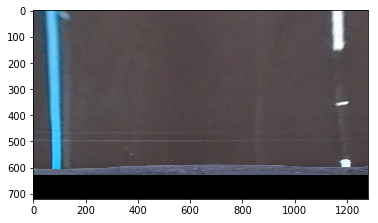

In [99]:
# print(warped_img)
fig1 = plt.figure()
plt.imshow(warped_img)

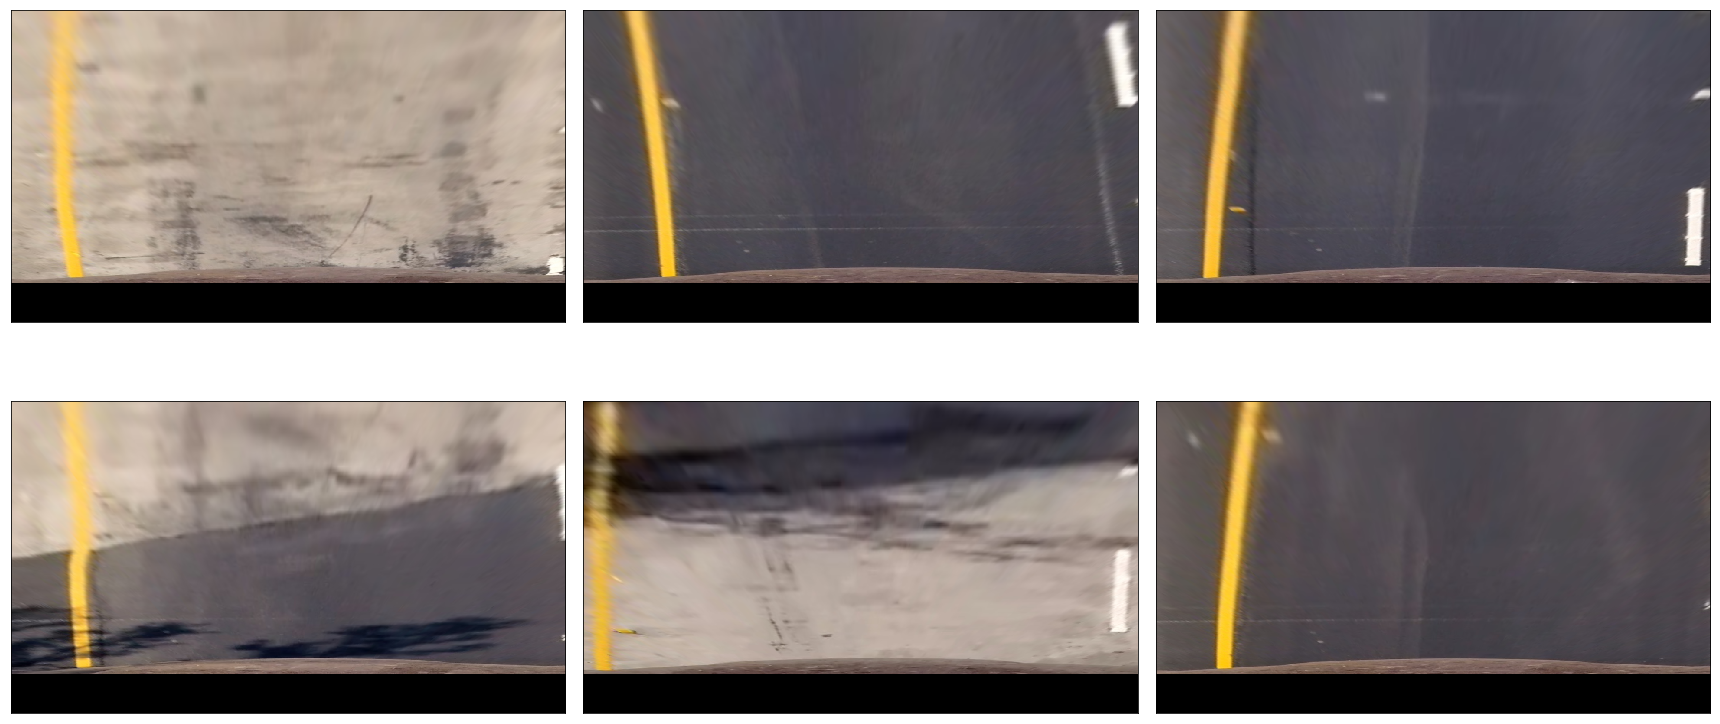

(720, 1280, 3)
(3, 3)


In [90]:
_test_images_len = len(glob.glob("test_images/test*.jpg"))
warped_imgs = np.zeros(shape=(img_shape[0], img_shape[1], img_shape[2], _test_images_len))
# 3 x 3 matrix of a perspective transform
M_perspective = np.zeros(shape=(3, 3, _test_images_len))

# img_path = './test_images/straight_lines2.jpg'
# img = cv2.imread(img_path)

def batch_warp_images(img_generator, nx=nx, ny=ny, base_points=base_points):
    enum_img = next(img_generator)
    img = mpimg.imread(enum_img[1])
    index = enum_img[0]
    warped_imgs[:, :, :, index] = warped(img, nx, ny, base_points)[0]
    M_perspective[:, :, index] = warped(img, nx, ny, base_points)[1]

# batch_warp_images((mpimg.imread(f) for f in cycle(glob.glob("test_images/test*.jpg"))))
batch_warp_images((f for f in enumerate(glob.glob("test_images/test*.jpg"))))

visualize("output_images/test_images_warped.jpg", (warped(undistort(mpimg.imread(f)), nx, ny, base_points)[0] for f in cycle(glob.glob("test_images/test*.jpg"))))

# print(warped_imgs[:, :, :, 0].shape)
# print(M_perspective[:, :, 0].shape)

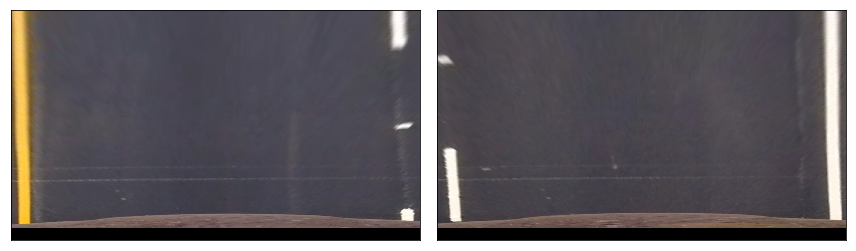

In [100]:

visualize_2("output_images/test_images_warped.jpg", (warped(undistort(mpimg.imread(f)), nx, ny, base_points, offset=50)[0] for f in cycle(glob.glob("test_images/straight*.jpg"))))